In [8]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
import os
import datetime

from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

# 한글 깨지는거 방지하기
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
mpl.rcParams['axes.unicode_minus'] = False   
#그래프에서 마이너스 기호가 표시되도록 하는 설정

In [9]:
# 훈련 데이터를 읽어온다

train = pd.read_csv("../input/AFSNT.csv", engine = "python", encoding = 'CP949')
# train = pd.read_csv('../input/AFSNT.csv')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987709 entries, 0 to 987708
Data columns (total 17 columns):
SDT_YY    987709 non-null int64
SDT_MM    987709 non-null int64
SDT_DD    987709 non-null int64
SDT_DY    987709 non-null object
ARP       987709 non-null object
ODP       987709 non-null object
FLO       987709 non-null object
FLT       987709 non-null object
REG       979446 non-null object
AOD       987709 non-null object
IRR       987709 non-null object
STT       987709 non-null object
ATT       987709 non-null object
DLY       987709 non-null object
DRR       118937 non-null object
CNL       987709 non-null object
CNR       8259 non-null object
dtypes: int64(3), object(14)
memory usage: 128.1+ MB


# 나머지 데이터 전처리

In [11]:
# 출발하는 데이터/ 도착하는 데이터로 구분
trainA = train[train.AOD == "A"]
print(len(trainA))
trainD = train[train.AOD == "D"]
print(len(trainD))

493992
493717


In [12]:
# 년, 월, 일, 요일, 항공사, 항공편, 식별번호로 묶어서 데이터 행 합치기
all_df = pd.merge(left=trainD, right=trainA, how='inner',on=['SDT_YY','SDT_MM','SDT_DD', "SDT_DY", "FLO", "FLT", "REG"], sort=False)
all_df.head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP_x,ODP_x,FLO,FLT,REG,AOD_x,IRR_x,STT_x,ATT_x,DLY_x,DRR_x,CNL_x,CNR_x,ARP_y,ODP_y,AOD_y,IRR_y,STT_y,ATT_y,DLY_y,DRR_y,CNL_y,CNR_y
0,2017,1,1,일,ARP3,ARP6,J,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN,ARP6,ARP3,A,N,11:10,11:18,N,NaN,N,NaN
1,2017,1,1,일,ARP3,ARP6,J,J1957,SEw3NzE4,D,N,13:25,14:09,Y,C02,N,NaN,ARP6,ARP3,A,N,14:30,14:56,N,NaN,N,NaN
2,2017,1,1,일,ARP3,ARP6,J,J1959,SEw3NTk5,D,N,16:45,17:21,Y,C02,N,NaN,ARP6,ARP3,A,N,17:50,18:07,N,NaN,N,NaN
3,2017,1,1,일,ARP3,ARP6,J,J1961,SEw3NTk5,D,N,20:35,20:52,N,NaN,N,NaN,ARP6,ARP3,A,N,21:40,21:39,N,NaN,N,NaN
4,2017,1,1,일,ARP1,ARP3,J,J1242,SEw3NzA2,D,N,20:25,20:36,N,NaN,N,NaN,ARP3,ARP1,A,N,21:30,21:27,N,NaN,N,NaN


In [13]:
## 결항된 데이터 제거를 위해 결항 갯수 확인

print(len(all_df))
all_df_x = all_df[all_df.CNL_x == "Y"]
print(len(all_df_x))
all_df_y = all_df[all_df.CNL_y == "Y"]
print(len(all_df_y))

492436
4079
4079


In [14]:
## 결항 데이터 제거

all_df = all_df[all_df.CNL_x == "N"]
print(len(all_df))

# 확인
print(all_df[all_df.CNL_x =="N"].count())
print(all_df[all_df.CNL_y =="N"].count())


488357
SDT_YY    488357
SDT_MM    488357
SDT_DD    488357
SDT_DY    488357
ARP_x     488357
ODP_x     488357
FLO       488357
FLT       488357
REG       488357
AOD_x     488357
IRR_x     488357
STT_x     488357
ATT_x     488357
DLY_x     488357
DRR_x      85645
CNL_x     488357
CNR_x          0
ARP_y     488357
ODP_y     488357
AOD_y     488357
IRR_y     488357
STT_y     488357
ATT_y     488357
DLY_y     488357
DRR_y      32720
CNL_y     488357
CNR_y          0
dtype: int64
SDT_YY    488357
SDT_MM    488357
SDT_DD    488357
SDT_DY    488357
ARP_x     488357
ODP_x     488357
FLO       488357
FLT       488357
REG       488357
AOD_x     488357
IRR_x     488357
STT_x     488357
ATT_x     488357
DLY_x     488357
DRR_x      85645
CNL_x     488357
CNR_x          0
ARP_y     488357
ODP_y     488357
AOD_y     488357
IRR_y     488357
STT_y     488357
ATT_y     488357
DLY_y     488357
DRR_y      32720
CNL_y     488357
CNR_y          0
dtype: int64


In [15]:
all_df.shape

(488357, 27)

In [16]:
# 필요없는 변수 제외하기
# 총 10개
# 겹치는 것 'ARP_y','ODP_y' = 공항, 상대공항 - 하나만 있으면 충분
# 필요없는 것 'AOD_x','AOD_y' = 출도착 여부 /'IRR_x','IRR_y' = 부정기편 여부 / 'CNL_x','CNR_x','CNL_y','CNR_y' = 결항관련 항목들
remove_variable = ['AOD_x','IRR_x','ARP_y','ODP_y','AOD_y','IRR_y','CNL_x','CNR_x','CNL_y','CNR_y']
all_df.drop(remove_variable, axis = 1, inplace = True)
all_df.head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP_x,ODP_x,FLO,FLT,REG,STT_x,ATT_x,DLY_x,DRR_x,STT_y,ATT_y,DLY_y,DRR_y
0,2017,1,1,일,ARP3,ARP6,J,J1955,SEw3NzE4,10:05,10:32,N,NaN,11:10,11:18,N,NaN
1,2017,1,1,일,ARP3,ARP6,J,J1957,SEw3NzE4,13:25,14:09,Y,C02,14:30,14:56,N,NaN
2,2017,1,1,일,ARP3,ARP6,J,J1959,SEw3NTk5,16:45,17:21,Y,C02,17:50,18:07,N,NaN
3,2017,1,1,일,ARP3,ARP6,J,J1961,SEw3NTk5,20:35,20:52,N,NaN,21:40,21:39,N,NaN
4,2017,1,1,일,ARP1,ARP3,J,J1242,SEw3NzA2,20:25,20:36,N,NaN,21:30,21:27,N,NaN


In [17]:
## 변수명 및 값들 한국어로 바꾸기

print('Dataframe dimensions:', all_df.shape)
all_df.columns = ['년','월','일', '요일', '공항', '상대공항', '항공사', '항공편', '식별번호', '예정출발시간',
             '실제출발시간','출발편지연여부', '출발편지연사유', '예정도착시간', '실제도착시간', '도착편지연여부', '도착편지연사유', ]
#recollist = ['년','월','일', '요일', '공항', '출도착', '상대공항', '항공사', '항공편', '식별번호', 
#              '계획', '실제', '지연', '지연사유', '결항', '결항사유', '부정기편']
#all_df = all_df[recollist]
transairport = {'ARP1':'김포', 'ARP2':'김해', 'ARP3': '제주', 'ARP4':'대구', 'ARP5': '울산',
           'ARP6':'청주', 'ARP7':'무안', 'ARP8':'광주', 'ARP9':'여수', 'ARP10':'양양',
           'ARP11':'포항', 'ARP12':'사천', 'ARP13':'군산', 'ARP14':'원주', 'ARP15':'인천'}
all_df['공항'] = all_df['공항'].apply(lambda x: transairport[x])
all_df['상대공항'] = all_df['상대공항'].apply(lambda x: transairport[x])
#train_inner["출도착"] = train_inner["출도착"].apply(lambda x: "출발" if x=="D" else x)
#train_inner["출도착"] = train_inner["출도착"].apply(lambda x: "도착" if x=="A" else x)
#df = df.iloc[df['항공사']!= ['C', 'D', 'E', 'G', 'K'],]
transairline = {'A':'아시아나', 'B':'에어부산', 'C': '전일본항공ANA', 'D':'에어서울', 'E': '불명',
           'F':'이스타', 'G':'일본항공', 'H':'제주항공', 'I':'진에어', 'J':'대한항공',
           'K':'타이완', 'L':'티웨이', 'M':'신규'}
all_df['항공사'] = all_df['항공사'].apply(lambda x: transairline[x])

Dataframe dimensions: (488357, 17)


In [18]:
all_df.head()

,년,월,일,요일,공항,상대공항,항공사,항공편,식별번호,예정출발시간,실제출발시간,출발편지연여부,출발편지연사유,예정도착시간,실제도착시간,도착편지연여부,도착편지연사유
0,2017,1,1,일,제주,청주,대한항공,J1955,SEw3NzE4,10:05,10:32,N,NaN,11:10,11:18,N,NaN
1,2017,1,1,일,제주,청주,대한항공,J1957,SEw3NzE4,13:25,14:09,Y,C02,14:30,14:56,N,NaN
2,2017,1,1,일,제주,청주,대한항공,J1959,SEw3NTk5,16:45,17:21,Y,C02,17:50,18:07,N,NaN
3,2017,1,1,일,제주,청주,대한항공,J1961,SEw3NTk5,20:35,20:52,N,NaN,21:40,21:39,N,NaN
4,2017,1,1,일,김포,제주,대한항공,J1242,SEw3NzA2,20:25,20:36,N,NaN,21:30,21:27,N,NaN


In [ ]:
all_df['예정출발시간'] = pd.to_datetime(all_df['예정출발시간'])
all_df['실제출발시간'] = pd.to_datetime(all_df['실제출발시간'])
all_df['예정도착시간'] = pd.to_datetime(all_df['예정도착시간'])
all_df['실제도착시간'] = pd.to_datetime(all_df['실제도착시간'])

In [ ]:
all_df['time_exp_dep'] = all_df['예정출발시간'].apply(lambda x : x.time().hour)
all_df['time_act_dep'] = all_df['실제출발시간'].apply(lambda x : x.time().hour)
all_df['time_exp_ari'] = all_df['예정도착시간'].apply(lambda x : x.time().hour)
all_df['time_act_ari'] = all_df['실제도착시간'].apply(lambda x : x.time().hour)

def nextday_time_mapping_dep(row):
  if (row['time_exp_dep'] >= 20) and ((row['time_act_dep'] >=0) and (row['time_act_dep'] <= 5)):
    return row['실제출발시간'] + timedelta(days = +1)
  else:
    return row['실제출발시간']

def nextday_time_mapping_ari(row):
  if (row['time_exp_ari'] >= 20.0) and ((row['time_act_ari'] >=0) and (row['time_act_ari'] <= 5)):
    return row['실제도착시간'] + timedelta(days = +1)
  else: 
    return row['실제도착시간']

In [27]:
print(pd.to_datetime('today').day)

today_day = pd.to_datetime('today').day

all_df['실제출발시간'] = all_df.apply(nextday_time_mapping_dep, axis = 1)
all_df['실제도착시간'] = all_df.apply(nextday_time_mapping_ari, axis = 1)


9


In [28]:
def check_dep(row):
#     print(row['실제출발시간'].day)
#     print(row)
    if row['실제출발시간'].day == today_day+1:
        print(row['실제출발시간'].day)

def check_ari(row):
#     print(row['실제출발시간'].day)
#     print(row)
    if row['실제도착시간'].day == today_day+1:
        print(row['실제도착시간'].day)

all_df.apply(check_dep, axis = 1)
all_df.apply(check_ari, axis = 1)


10
10
10
10
10
10
10
10
10
10
10
10


0         None
1         None
2         None
3         None
4         None
          ... 
492431    None
492432    None
492433    None
492434    None
492435    None
Length: 488357, dtype: object

In [29]:
## 지역시간x , 지연시간 y , 계획 비행 시간 차이, 실제 비행 시간 차이 구하기 
all_df["x_차이"] = all_df["실제출발시간"] - all_df["예정출발시간"]
all_df["y_차이"] = all_df["실제도착시간"] - all_df["예정도착시간"]
all_df["plan_차이"] = all_df["예정도착시간"] - all_df["예정출발시간"]
all_df["true_차이"] = all_df["실제도착시간"] - all_df["실제출발시간"]
## - 값을 따로 넣어주기 위해 양수, 음수 값 변환
all_df["x_차이_minus"] = all_df["예정출발시간"] - all_df["실제출발시간"]
all_df["y_차이_minus"] = all_df["예정도착시간"] - all_df["실제도착시간"]
all_df["plan_차이_minus"] = all_df["예정출발시간"] - all_df["예정도착시간"]
all_df["true_차이_minus"] = all_df["실제출발시간"] - all_df["실제도착시간"]
## 더 빨리 도착한 값은 -를 붙여서 변환, 지연된 값은 그대로 저장
all_df['x_차이'][all_df['x_차이'].astype('timedelta64[m]') > 0 ] =   all_df['x_차이'].astype('timedelta64[m]') 
all_df['x_차이'][all_df['x_차이_minus'].astype('timedelta64[m]') > 0 ] = 0 - all_df['x_차이_minus'].astype('timedelta64[m]') 
all_df['y_차이'][all_df['y_차이'].astype('timedelta64[m]') > 0 ] =   all_df['y_차이'].astype('timedelta64[m]') 
all_df['y_차이'][all_df['y_차이_minus'].astype('timedelta64[m]') > 0 ] = 0 - all_df['y_차이_minus'].astype('timedelta64[m]') 
all_df['plan_차이'][all_df['plan_차이'].astype('timedelta64[m]') > 0 ] =   all_df['plan_차이'].astype('timedelta64[m]') 
all_df['plan_차이'][all_df['plan_차이_minus'].astype('timedelta64[m]') > 0 ] = 0 - all_df['plan_차이_minus'].astype('timedelta64[m]') 
all_df['true_차이'][all_df['true_차이'].astype('timedelta64[m]') > 0 ] =   all_df['true_차이'].astype('timedelta64[m]') 
all_df['true_차이'][all_df['true_차이_minus'].astype('timedelta64[m]') > 0 ] = 0 - all_df['true_차이_minus'].astype('timedelta64[m]') 
## minus 칼럼 제거 
all_df = all_df.drop(["x_차이_minus", "y_차이_minus", "plan_차이_minus","true_차이_minus"], axis = 1)


In [30]:
idx_1 = all_df[((all_df['x_차이'] > 30) | (all_df['x_차이'] < -30.0)) & (all_df['출발편지연여부'] == 'N')].index
all_df = all_df.drop(idx_1,axis = 0)
idx_2 = all_df[((all_df['x_차이'] <= 30) & (all_df['x_차이'] >= -30.0)) & (all_df['출발편지연여부'] == 'Y')].index
all_df = all_df.drop(idx_2,axis = 0)
idx_3 = all_df[((all_df['y_차이'] > 30) | (all_df['y_차이'] < -30.0)) & (all_df['도착편지연여부'] == 'N')].index
all_df = all_df.drop(idx_3,axis = 0)
idx_4 = all_df[((all_df['y_차이'] <= 30) & (all_df['y_차이'] >= -30.0)) & (all_df['도착편지연여부'] == 'Y')].index
all_df = all_df.drop(idx_4,axis = 0)
all_df.shape

(487695, 25)

In [31]:
all_df["비행시간차이"] = all_df["plan_차이"] - all_df["true_차이"]

all_df.head()

,년,월,일,요일,공항,상대공항,항공사,항공편,식별번호,예정출발시간,실제출발시간,출발편지연여부,출발편지연사유,예정도착시간,실제도착시간,도착편지연여부,도착편지연사유,time_exp_dep,time_act_dep,time_exp_ari,time_act_ari,x_차이,y_차이,plan_차이,true_차이,비행시간차이
0,2017,1,1,일,제주,청주,대한항공,J1955,SEw3NzE4,2019-09-09 10:05:00,2019-09-09 10:32:00,N,NaN,2019-09-09 11:10:00,2019-09-09 11:18:00,N,NaN,10,10,11,11,27.0,8.0,65.0,46.0,19.0
1,2017,1,1,일,제주,청주,대한항공,J1957,SEw3NzE4,2019-09-09 13:25:00,2019-09-09 14:09:00,Y,C02,2019-09-09 14:30:00,2019-09-09 14:56:00,N,NaN,13,14,14,14,44.0,26.0,65.0,47.0,18.0
2,2017,1,1,일,제주,청주,대한항공,J1959,SEw3NTk5,2019-09-09 16:45:00,2019-09-09 17:21:00,Y,C02,2019-09-09 17:50:00,2019-09-09 18:07:00,N,NaN,16,17,17,18,36.0,17.0,65.0,46.0,19.0
3,2017,1,1,일,제주,청주,대한항공,J1961,SEw3NTk5,2019-09-09 20:35:00,2019-09-09 20:52:00,N,NaN,2019-09-09 21:40:00,2019-09-09 21:39:00,N,NaN,20,20,21,21,17.0,-1.0,65.0,47.0,18.0
4,2017,1,1,일,김포,제주,대한항공,J1242,SEw3NzA2,2019-09-09 20:25:00,2019-09-09 20:36:00,N,NaN,2019-09-09 21:30:00,2019-09-09 21:27:00,N,NaN,20,20,21,21,11.0,-3.0,65.0,51.0,14.0


# all_df 파일 쓰기

In [ ]:
all_df.to_csv('all_df.csv', encoding = "CP949")

# 여기서부터는 EDA를 위한 코드

In [32]:
all_df['count'] = 1
all_df.head()

,년,월,일,요일,공항,상대공항,항공사,항공편,식별번호,예정출발시간,실제출발시간,출발편지연여부,출발편지연사유,예정도착시간,실제도착시간,도착편지연여부,도착편지연사유,time_exp_dep,time_act_dep,time_exp_ari,time_act_ari,x_차이,y_차이,plan_차이,true_차이,비행시간차이,count
0,2017,1,1,일,제주,청주,대한항공,J1955,SEw3NzE4,2019-09-09 10:05:00,2019-09-09 10:32:00,N,NaN,2019-09-09 11:10:00,2019-09-09 11:18:00,N,NaN,10,10,11,11,27.0,8.0,65.0,46.0,19.0,1
1,2017,1,1,일,제주,청주,대한항공,J1957,SEw3NzE4,2019-09-09 13:25:00,2019-09-09 14:09:00,Y,C02,2019-09-09 14:30:00,2019-09-09 14:56:00,N,NaN,13,14,14,14,44.0,26.0,65.0,47.0,18.0,1
2,2017,1,1,일,제주,청주,대한항공,J1959,SEw3NTk5,2019-09-09 16:45:00,2019-09-09 17:21:00,Y,C02,2019-09-09 17:50:00,2019-09-09 18:07:00,N,NaN,16,17,17,18,36.0,17.0,65.0,46.0,19.0,1
3,2017,1,1,일,제주,청주,대한항공,J1961,SEw3NTk5,2019-09-09 20:35:00,2019-09-09 20:52:00,N,NaN,2019-09-09 21:40:00,2019-09-09 21:39:00,N,NaN,20,20,21,21,17.0,-1.0,65.0,47.0,18.0,1
4,2017,1,1,일,김포,제주,대한항공,J1242,SEw3NzA2,2019-09-09 20:25:00,2019-09-09 20:36:00,N,NaN,2019-09-09 21:30:00,2019-09-09 21:27:00,N,NaN,20,20,21,21,11.0,-3.0,65.0,51.0,14.0,1


# EDA 시각화

## 전체적인 부분 보기

    항공사     비율
0  대한항공  27.91
1  아시아나  17.91
2  에어부산  13.71
3  제주항공  13.37
4   진에어   9.65
5   이스타   8.94
6   티웨이   8.51


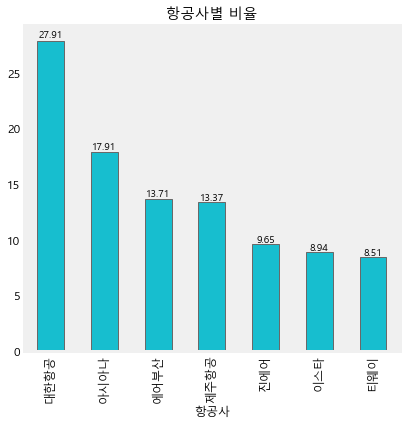

In [34]:
len(all_df) # 488357

airline_count = pd.pivot_table(all_df, index = ["항공사"], values = ["count"], aggfunc = np.sum)

airline_rate = airline_count.iloc[:,0] / len(all_df) * 100
airline_rate = round(airline_rate, 2)
airline_rate = pd.DataFrame({'항공사':airline_rate.index, '비율':airline_rate.values})
airline_rate = airline_rate.sort_values(["비율"], ascending = False)
airline_rate = airline_rate.reset_index(drop = True)
airline_rate = airline_rate.reindex(airline_rate.index.drop(7))
print(airline_rate)

ax = airline_rate.plot(x = "항공사", y = "비율", kind = "bar",title = "항공사별 비율", figsize = (6,6), fontsize = 12, grid = False, legend = False, color = ['tab:cyan'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')


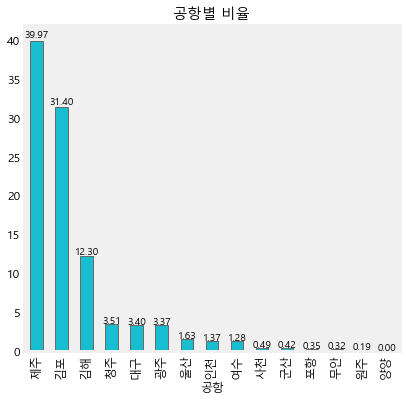

In [35]:
airport_count = pd.pivot_table(all_df, index = ["공항"], values = ["count"], aggfunc = np.sum)

airport_rate = airport_count.iloc[:,0] / len(all_df) * 100
airport_rate = round(airport_rate, 3)
airport_rate = pd.DataFrame({'공항':airport_rate.index, '비율':airport_rate.values})
airport_rate = airport_rate.sort_values(["비율"], ascending = False)
airport_rate = airport_rate.reset_index(drop = True)
airport_rate

ax = airport_rate.plot(x = "공항", y = "비율", kind = "bar",title = "공항별 비율", figsize = (6,6), fontsize = 12, grid = False, legend = False, color = ['tab:cyan'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')

## 항공사별 시각화

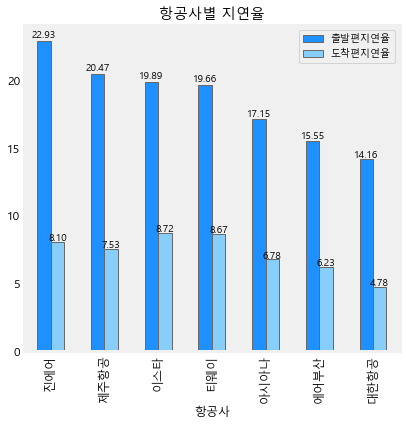

In [73]:
departure_DLY_count = pd.pivot_table(all_df, index = ["항공사"], columns = ['출발편지연여부'], values = ["count"], aggfunc = np.sum)

departure_DLY_rate = departure_DLY_count.iloc[:,1] / (departure_DLY_count.iloc[:,0] + departure_DLY_count.iloc[:,1]) * 100
departure_DLY_rate = round(departure_DLY_rate, 2)
departure_DLY_rate = pd.DataFrame({'항공사':departure_DLY_rate.index, '출발편지연율':departure_DLY_rate.values})


arrival_DLY_count = pd.pivot_table(all_df, index = ["항공사"], columns = ['도착편지연여부'], values = ["count"], aggfunc = np.sum)

arrival_DLY_rate = arrival_DLY_count.iloc[:,1] / (arrival_DLY_count.iloc[:,0] + arrival_DLY_count.iloc[:,1]) * 100
arrival_DLY_rate = round(arrival_DLY_rate, 2)
arrival_DLY_rate = pd.DataFrame({'항공사':arrival_DLY_rate.index, '도착편지연율':arrival_DLY_rate.values})


airline_DLY_rate = pd.merge(departure_DLY_rate, arrival_DLY_rate, on = "항공사")
airline_DLY_rate = airline_DLY_rate.sort_values(["출발편지연율"], ascending = False)
airline_DLY_rate = airline_DLY_rate.reset_index(drop = True)
airline_DLY_rate = airline_DLY_rate.reindex(airline_DLY_rate.index.drop(7))
airline_DLY_rate

ax = airline_DLY_rate.plot(x = "항공사",  kind = "bar",title = "항공사별 지연율", figsize = (6,6), fontsize = 12, grid = False, color = ['dodgerblue', 'lightskyblue'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')

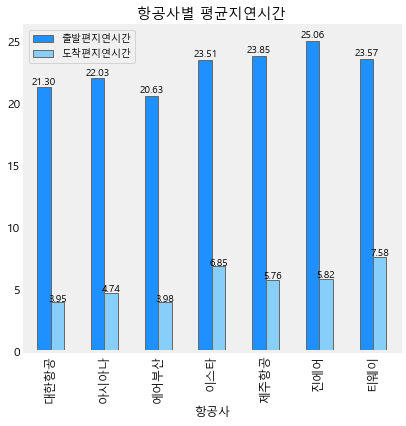

In [37]:
airline_DLY_mean = pd.pivot_table(all_df, index = ["항공사"], values = ["x_차이","y_차이"], aggfunc = np.mean)

airline_DLY_mean = round(airline_DLY_mean, 2)
airline_DLY_mean = pd.DataFrame({'항공사':airline_DLY_mean.index, '출발편지연시간':airline_DLY_mean.iloc[:,0], '도착편지연시간':airline_DLY_mean.iloc[:,1]})

airline_DLY_mean = airline_DLY_mean.reindex(airline_DLY_mean.index.drop('타이완'))
airline_DLY_mean

ax = airline_DLY_mean.plot(x = "항공사",  kind = "bar",title = "항공사별 평균지연시간", figsize = (6,6), fontsize = 12, grid = False, color = ['dodgerblue', 'lightskyblue'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')

## 공항별 시각화

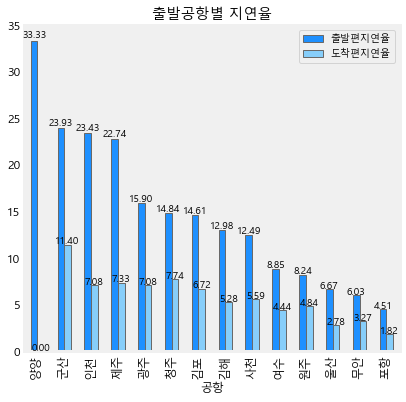

In [71]:
departure_DLY_count = pd.pivot_table(all_df, index = ["공항"], columns = ['출발편지연여부'], values = ["count"], aggfunc = np.sum)

departure_DLY_rate = departure_DLY_count.iloc[:,1] / (departure_DLY_count.iloc[:,0] + departure_DLY_count.iloc[:,1]) * 100
departure_DLY_rate = round(departure_DLY_rate, 2)
departure_DLY_rate = pd.DataFrame({'공항':departure_DLY_rate.index, '출발편지연율':departure_DLY_rate.values})


arrival_DLY_count = pd.pivot_table(all_df, index = ["공항"], columns = ['도착편지연여부'], values = ["count"], aggfunc = np.sum)

arrival_DLY_rate = arrival_DLY_count.iloc[:,1] / (arrival_DLY_count.iloc[:,0] + arrival_DLY_count.iloc[:,1]) * 100
arrival_DLY_rate = round(arrival_DLY_rate, 2)
arrival_DLY_rate = pd.DataFrame({'공항':arrival_DLY_rate.index, '도착편지연율':arrival_DLY_rate.values})


Dairport_DLY_rate = pd.merge(departure_DLY_rate, arrival_DLY_rate, on = "공항")
Dairport_DLY_rate = Dairport_DLY_rate.sort_values(["출발편지연율"], ascending = False)
Dairport_DLY_rate = Dairport_DLY_rate.reset_index(drop = True)
Dairport_DLY_rate = Dairport_DLY_rate.reindex(Dairport_DLY_rate.index.drop(7))
Dairport_DLY_rate

ax = Dairport_DLY_rate.plot(x = "공항",  kind = "bar",title = "출발공항별 지연율", figsize = (6,6), fontsize = 12, grid = False, color = ['dodgerblue', 'lightskyblue'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')

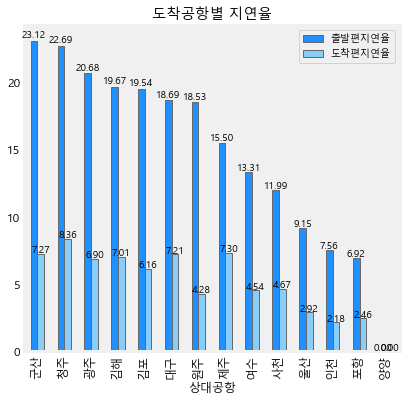

In [72]:
departure_DLY_count = pd.pivot_table(all_df, index = ["상대공항"], columns = ['출발편지연여부'], values = ["count"], aggfunc = np.sum)

departure_DLY_rate = departure_DLY_count.iloc[:,1] / (departure_DLY_count.iloc[:,0] + departure_DLY_count.iloc[:,1]) * 100
departure_DLY_rate = round(departure_DLY_rate, 2)
departure_DLY_rate = pd.DataFrame({'상대공항':departure_DLY_rate.index, '출발편지연율':departure_DLY_rate.values})


arrival_DLY_count = pd.pivot_table(all_df, index = ["상대공항"], columns = ['도착편지연여부'], values = ["count"], aggfunc = np.sum)

arrival_DLY_rate = arrival_DLY_count.iloc[:,1] / (arrival_DLY_count.iloc[:,0] + arrival_DLY_count.iloc[:,1]) * 100
arrival_DLY_rate = round(arrival_DLY_rate, 2)
arrival_DLY_rate = pd.DataFrame({'상대공항':arrival_DLY_rate.index, '도착편지연율':arrival_DLY_rate.values})


Aairport_DLY_rate = pd.merge(departure_DLY_rate, arrival_DLY_rate, on = "상대공항")
Aairport_DLY_rate = Aairport_DLY_rate.sort_values(["출발편지연율"], ascending = False)
Aairport_DLY_rate = Aairport_DLY_rate.reset_index(drop = True)
Aairport_DLY_rate = Aairport_DLY_rate.reindex(Aairport_DLY_rate.index.drop(7))
Aairport_DLY_rate

ax = Aairport_DLY_rate.plot(x = "상대공항",  kind = "bar",title = "도착공항별 지연율", figsize = (6,6), fontsize = 12, grid = False, color = ['dodgerblue', 'lightskyblue'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')

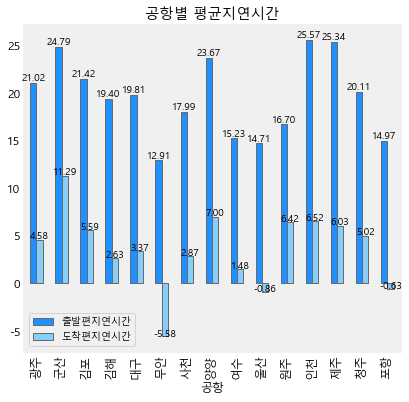

In [40]:
airport_DLY_mean = pd.pivot_table(all_df, index = ["공항"], values = ["x_차이","y_차이"], aggfunc = np.mean)

airport_DLY_mean = round(airport_DLY_mean, 2)
airport_DLY_mean = pd.DataFrame({'공항':airport_DLY_mean.index, '출발편지연시간':airport_DLY_mean.iloc[:,0], '도착편지연시간':airport_DLY_mean.iloc[:,1]})


ax = airport_DLY_mean.plot(x = "공항",  kind = "bar",title = "공항별 평균지연시간", figsize = (6,6), fontsize = 12, grid = False, color = ['dodgerblue', 'lightskyblue'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')

## 날짜별(월, 주차, 요일별) 시각화

### 월별 시각화

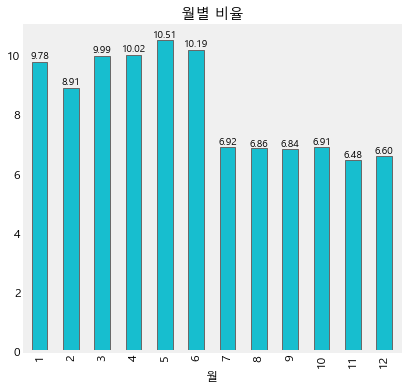

In [42]:
# 2019년은 6월까지 있다는 것을 고려하면 조정 조금 필요할듯

month_count = pd.pivot_table(all_df, index = ["월"], values = ["count"], aggfunc = np.sum)

month_rate = month_count.iloc[:,0] / len(all_df) * 100
month_rate = round(month_rate, 2)
month_rate = pd.DataFrame({'월':month_rate.index, '비율':month_rate.values})

ax = month_rate.plot(x = "월", y = "비율", kind = "bar",title = "월별 비율", figsize = (6,6), fontsize = 12, grid = False, legend = False, color = ['tab:cyan'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')

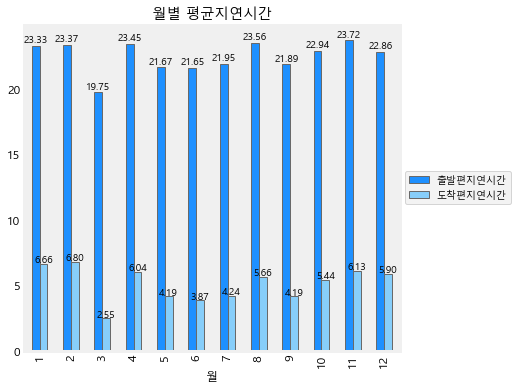

In [43]:
month_DLY_mean = pd.pivot_table(all_df, index = ["월"], values = ["x_차이","y_차이"], aggfunc = np.mean)

month_DLY_mean = round(month_DLY_mean, 2)
month_DLY_mean = pd.DataFrame({'월':month_DLY_mean.index, '출발편지연시간':month_DLY_mean.iloc[:,0], '도착편지연시간':month_DLY_mean.iloc[:,1]})


ax = month_DLY_mean.plot(x = "월",  kind = "bar",title = "월별 평균지연시간", figsize = (6,6), fontsize = 12, grid = False, color = ['dodgerblue', 'lightskyblue'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')

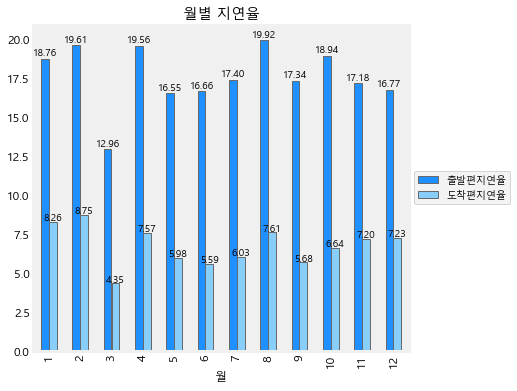

In [70]:
month_departure_DLY_count = pd.pivot_table(all_df, index = ["월"], columns = ['출발편지연여부'], values = ["count"], aggfunc = np.sum)

month_departure_DLY_rate = month_departure_DLY_count.iloc[:,1] / (month_departure_DLY_count.iloc[:,0] + month_departure_DLY_count.iloc[:,1]) * 100
month_departure_DLY_rate = round(month_departure_DLY_rate, 2)
month_departure_DLY_rate = pd.DataFrame({'월':month_departure_DLY_rate.index, '출발편지연율':month_departure_DLY_rate.values})


month_arrival_DLY_count = pd.pivot_table(all_df, index = ["월"], columns = ['도착편지연여부'], values = ["count"], aggfunc = np.sum)

month_arrival_DLY_rate = month_arrival_DLY_count.iloc[:,1] / (month_arrival_DLY_count.iloc[:,0] + month_arrival_DLY_count.iloc[:,1]) * 100
month_arrival_DLY_rate = round(month_arrival_DLY_rate, 2)
month_arrival_DLY_rate = pd.DataFrame({'월':month_arrival_DLY_rate.index, '도착편지연율':month_arrival_DLY_rate.values})


month_DLY_rate = pd.merge(month_departure_DLY_rate, month_arrival_DLY_rate, on = "월")


ax = month_DLY_rate.plot(x = "월",  kind = "bar",title = "월별 지연율", figsize = (6,6), fontsize = 12, grid = False, color = ['dodgerblue', 'lightskyblue'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')

### 요일별 시각화

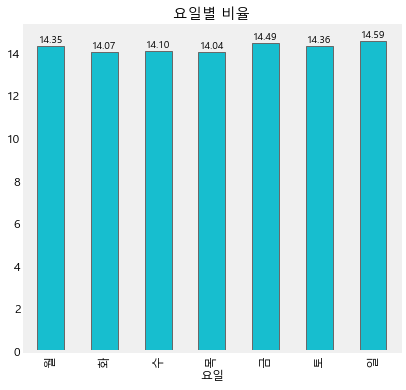

In [77]:
day_count = pd.pivot_table(all_df, index = ["요일"], values = ["count"], aggfunc = np.sum)

day_rate = day_count.iloc[:,0] / len(all_df) * 100
day_rate = round(day_rate, 2)
day_rate = pd.DataFrame({'요일':day_rate.index, '비율':day_rate.values})
# 요일 순서조정
day_rate = day_rate.reindex(index = [3,6,2,1,0,5,4])

ax = day_rate.plot(x = "요일", y = "비율", kind = "bar",title = "요일별 비율", figsize = (6,6), fontsize = 12, grid = False, legend = False, color = ['tab:cyan'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')

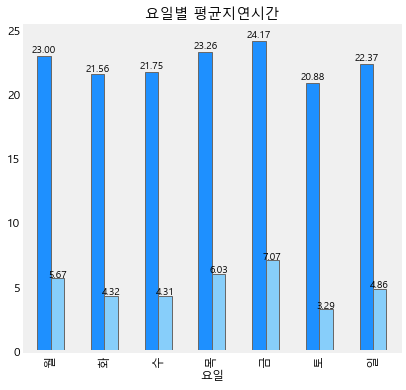

In [88]:
day_DLY_mean = pd.pivot_table(all_df, index = ["요일"], values = ["x_차이","y_차이"], aggfunc = np.mean)

day_DLY_mean = round(day_DLY_mean, 2)
day_DLY_mean = pd.DataFrame({'요일':day_DLY_mean.index, '출발편지연시간':day_DLY_mean.iloc[:,0], '도착편지연시간':day_DLY_mean.iloc[:,1]})
# 요일 순서조정
day_DLY_mean = day_DLY_mean.reindex(index = ['월','화','수','목','금','토','일'])

ax = day_DLY_mean.plot(x = "요일",  kind = "bar",title = "요일별 평균지연시간", figsize = (6,6), legend = False, fontsize = 12, grid = False, color = ['dodgerblue', 'lightskyblue'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')

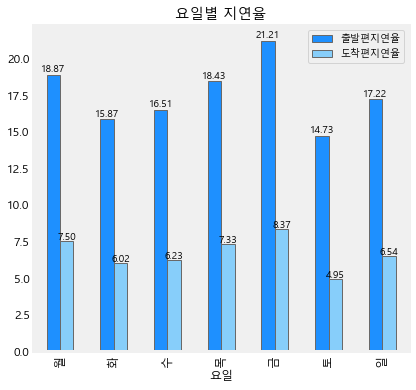

In [86]:
day_departure_DLY_count = pd.pivot_table(all_df, index = ["요일"], columns = ['출발편지연여부'], values = ["count"], aggfunc = np.sum)

day_departure_DLY_rate = day_departure_DLY_count.iloc[:,1] / (day_departure_DLY_count.iloc[:,0] + day_departure_DLY_count.iloc[:,1]) * 100
day_departure_DLY_rate = round(day_departure_DLY_rate, 2)
day_departure_DLY_rate = pd.DataFrame({'요일':day_departure_DLY_rate.index, '출발편지연율':day_departure_DLY_rate.values})


day_arrival_DLY_count = pd.pivot_table(all_df, index = ["요일"], columns = ['도착편지연여부'], values = ["count"], aggfunc = np.sum)

day_arrival_DLY_rate = day_arrival_DLY_count.iloc[:,1] / (day_arrival_DLY_count.iloc[:,0] + day_arrival_DLY_count.iloc[:,1]) * 100
day_arrival_DLY_rate = round(day_arrival_DLY_rate, 2)
day_arrival_DLY_rate = pd.DataFrame({'요일':day_arrival_DLY_rate.index, '도착편지연율':day_arrival_DLY_rate.values})


day_DLY_rate = pd.merge(day_departure_DLY_rate, day_arrival_DLY_rate, on = "요일")
# 요일 순서조정
day_DLY_rate = day_DLY_rate.reindex(index = [3,6,2,1,0,5,4])


ax = day_DLY_rate.plot(x = "요일",  kind = "bar",title = "요일별 지연율", figsize = (6,6), fontsize = 12, grid = False, color = ['dodgerblue', 'lightskyblue'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')

## 출발시간대별 시각화

In [53]:
all_df.head()

,년,월,일,요일,공항,상대공항,항공사,항공편,식별번호,예정출발시간,실제출발시간,출발편지연여부,출발편지연사유,예정도착시간,실제도착시간,도착편지연여부,도착편지연사유,time_exp_dep,time_act_dep,time_exp_ari,time_act_ari,x_차이,y_차이,plan_차이,true_차이,비행시간차이,count
0,2017,1,1,일,제주,청주,대한항공,J1955,SEw3NzE4,2019-09-09 10:05:00,2019-09-09 10:32:00,N,NaN,2019-09-09 11:10:00,2019-09-09 11:18:00,N,NaN,10,10,11,11,27.0,8.0,65.0,46.0,19.0,1
1,2017,1,1,일,제주,청주,대한항공,J1957,SEw3NzE4,2019-09-09 13:25:00,2019-09-09 14:09:00,Y,C02,2019-09-09 14:30:00,2019-09-09 14:56:00,N,NaN,13,14,14,14,44.0,26.0,65.0,47.0,18.0,1
2,2017,1,1,일,제주,청주,대한항공,J1959,SEw3NTk5,2019-09-09 16:45:00,2019-09-09 17:21:00,Y,C02,2019-09-09 17:50:00,2019-09-09 18:07:00,N,NaN,16,17,17,18,36.0,17.0,65.0,46.0,19.0,1
3,2017,1,1,일,제주,청주,대한항공,J1961,SEw3NTk5,2019-09-09 20:35:00,2019-09-09 20:52:00,N,NaN,2019-09-09 21:40:00,2019-09-09 21:39:00,N,NaN,20,20,21,21,17.0,-1.0,65.0,47.0,18.0,1
4,2017,1,1,일,김포,제주,대한항공,J1242,SEw3NzA2,2019-09-09 20:25:00,2019-09-09 20:36:00,N,NaN,2019-09-09 21:30:00,2019-09-09 21:27:00,N,NaN,20,20,21,21,11.0,-3.0,65.0,51.0,14.0,1


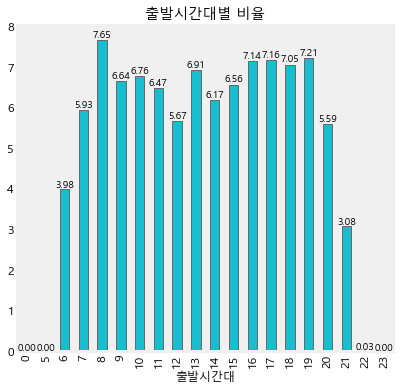

In [56]:
time_dep_count = pd.pivot_table(all_df, index = ["time_exp_dep"], values = ["count"], aggfunc = np.sum)

time_dep_rate = time_dep_count.iloc[:,0] / len(all_df) * 100
time_dep_rate = round(time_dep_rate, 2)
time_dep_rate = pd.DataFrame({'출발시간대':time_dep_rate.index, '비율':time_dep_rate.values})

ax = time_dep_rate.plot(x = "출발시간대", y = "비율", kind = "bar",title = "출발시간대별 비율", figsize = (6,6), fontsize = 12, grid = False, legend = False, color = ['tab:cyan'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')

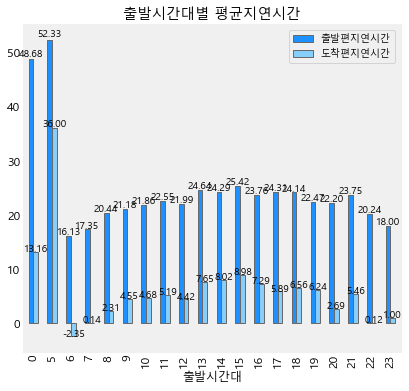

In [57]:
time_dep_DLY_mean = pd.pivot_table(all_df, index = ["time_exp_dep"], values = ["x_차이","y_차이"], aggfunc = np.mean)

time_dep_DLY_mean = round(time_dep_DLY_mean, 2)
time_dep_DLY_mean = pd.DataFrame({'출발시간대':time_dep_DLY_mean.index, '출발편지연시간':time_dep_DLY_mean.iloc[:,0], '도착편지연시간':time_dep_DLY_mean.iloc[:,1]})


ax = time_dep_DLY_mean.plot(x = "출발시간대",  kind = "bar",title = "출발시간대별 평균지연시간", figsize = (6,6), fontsize = 12, grid = False, color = ['dodgerblue', 'lightskyblue'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')

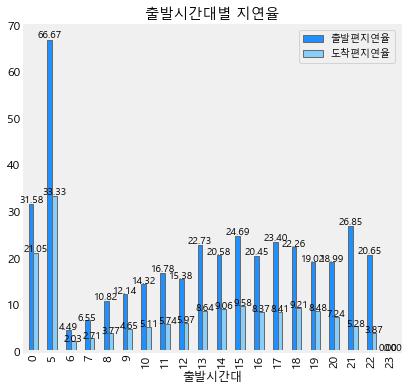

In [74]:
time_dep_departure_DLY_count = pd.pivot_table(all_df, index = ["time_exp_dep"], columns = ['출발편지연여부'], values = ["count"], aggfunc = np.sum)

time_dep_departure_DLY_rate = time_dep_departure_DLY_count.iloc[:,1] / (time_dep_departure_DLY_count.iloc[:,0]+time_dep_departure_DLY_count.iloc[:,1]) * 100
time_dep_departure_DLY_rate = round(time_dep_departure_DLY_rate, 2)
time_dep_departure_DLY_rate = pd.DataFrame({'출발시간대':time_dep_departure_DLY_rate.index, '출발편지연율':time_dep_departure_DLY_rate.values})


time_dep_arrival_DLY_count = pd.pivot_table(all_df, index = ["time_exp_dep"], columns = ['도착편지연여부'], values = ["count"], aggfunc = np.sum)

time_dep_arrival_DLY_rate = time_dep_arrival_DLY_count.iloc[:,1] / (time_dep_arrival_DLY_count.iloc[:,0]+time_dep_arrival_DLY_count.iloc[:,1]) * 100
time_dep_arrival_DLY_rate = round(time_dep_arrival_DLY_rate, 2)
time_dep_arrival_DLY_rate = pd.DataFrame({'출발시간대':time_dep_arrival_DLY_rate.index, '도착편지연율':time_dep_arrival_DLY_rate.values})


time_dep_DLY_rate = pd.merge(time_dep_departure_DLY_rate, time_dep_arrival_DLY_rate, on = "출발시간대")


ax = time_dep_DLY_rate.plot(x = "출발시간대",  kind = "bar",title = "출발시간대별 지연율", figsize = (6,6), fontsize = 12, grid = False, color = ['dodgerblue', 'lightskyblue'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.01), ha='center')